In [1]:
from pathlib import Path
import plotly.express as px
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import wandb
import torch
from torch import nn
from itertools import product
import sys
from tqdm.notebook import tqdm
sys.path.append(str(Path.cwd().parent))
from src.data.demand_design import psi, f
from viz_utils import load_dfiv_model, predict_dfiv_model, load_dfiv_runs

In [2]:
from ivtk.alg.spaceiv import spaceiv

In [3]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({
    "figure.figsize": [7.50, 4.50],
    "figure.autolayout": True,
    "text.usetex": False,
    "font.family": "sans-serif",
    'font.size': 16
})

In [4]:
PARCS_CONFIG_DIR = Path('src') / 'data' / 'parcs_simulation' / 'config'

In [5]:
entity, project = "jasmineqy0", "formal_7"  
rho = 0.5

In [6]:
group = 'dfiv_low_dim_parcs'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# original_test_loss = runs_df['summary'].apply(lambda x: x['min_test_loss']).tolist()
# original_rho = runs_df['config'].apply(lambda x: x['data_configs']['rho']).tolist()
# # original_data_size = runs_df['config'].apply(lambda x: x['data_configs']['data_size'])
# len(original_test_loss), len(original_rho)

# Visualization

In [74]:
viz_prep_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['function'] == 'original')]
len(viz_prep_df)

300

In [69]:
grouped_df = viz_prep_df.groupby(viz_prep_df['config'].apply(lambda x: x['data_configs']['rho']))


original_rhos = []
run_ids, run_seeds = {}, []
best_run_ids, best_run_seeds = [], []
original_mean_test_loss_list = []
original_std_test_loss_list = []
original_median_test_loss_list = []
original_test_loss_list = {}
original_data_sizes = {}
for group, group_df in grouped_df:
    n = len(group_df)
    print("Group:", group, 'Length:', n)
    
    original_rhos.append(group)
    
    run_id = group_df['id']
    run_ids[group] = run_id
    
    best_run_df_id = group_df['summary'].apply(lambda x: x['min_test_loss']).idxmin()
    best_run_id = group_df.loc[best_run_df_id]['id']
    best_run_ids.append(best_run_id)
    print('\t best run id: ', best_run_id)
    
    original_data_size = group_df['config'].apply(lambda x: x['data_configs']['data_size'])
    original_data_sizes[group] = original_data_size
    
    run_seed = group_df['config'].apply(lambda x: x['experiment_id'])
    run_seeds.append(run_seed)
    
    best_run_seed = group_df.loc[best_run_df_id]['config']['experiment_id']
    best_run_seeds.append(best_run_seed)
    print('\t best run seed: ', best_run_seed)
    
    test_loss_idx = group_df['summary'].apply(lambda x: True if 'min_test_loss' in x else False)
    test_loss_df = group_df[test_loss_idx]
    print('\t Number of runs with test loss: ', len(test_loss_df))

    original_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])
    original_test_loss_list[group] = original_test_loss

    min_idx, min_test_loss = np.argmin(original_test_loss), np.min(original_test_loss)
    print(f"\t min test loss: {min_test_loss}")

    original_mean_test_loss = np.mean(original_test_loss)
    original_mean_test_loss_list.append(original_mean_test_loss)
    print('\t mean test loss: ', original_mean_test_loss)

    original_std_test_loss = np.std(original_test_loss)
    original_std_test_loss_list.append(original_std_test_loss)
    print('\t std test loss: ', original_std_test_loss)

    original_median_test_loss = np.median(original_test_loss)
    original_median_test_loss_list.append(original_median_test_loss)
    print('\tmedian test loss: ', original_median_test_loss)

Group: 0.1 Length: 60
	 best run id:  7z2i9bdn
	 best run seed:  1
	 Number of runs with test loss:  60
	 min test loss: 52.91168975830078
	 mean test loss:  75.29901034037272
	 std test loss:  11.967363163909495
	median test loss:  74.10586929321289
Group: 0.3 Length: 60
	 best run id:  yglblz5a
	 best run seed:  1
	 Number of runs with test loss:  60
	 min test loss: 48.66018295288086
	 mean test loss:  72.68782285054525
	 std test loss:  13.526608870959452
	median test loss:  70.09551620483398
Group: 0.5 Length: 60
	 best run id:  thm0wwry
	 best run seed:  28
	 Number of runs with test loss:  60
	 min test loss: 46.693233489990234
	 mean test loss:  69.39695491790772
	 std test loss:  10.760331310962183
	median test loss:  69.52937316894531
Group: 0.7 Length: 60
	 best run id:  mfz5kq5o
	 best run seed:  8
	 Number of runs with test loss:  60
	 min test loss: 43.03330993652344
	 mean test loss:  72.96509583791097
	 std test loss:  11.13658238966414
	median test loss:  72.0775794982

In [70]:
from itertools import chain

viz_rhos = [[rho] * len(original_test_loss_list[rho]) for rho in original_rhos]
viz_test_loss = [original_test_loss_list[rho] for rho in original_rhos]
viz_data_size = [original_data_sizes[rho] for rho in original_rhos]

viz_rhos = list(chain(*viz_rhos))
viz_test_loss = list(chain(*viz_test_loss))
viz_data_size = list(chain(*viz_data_size))

In [71]:
viz_df = pd.DataFrame({ 'rho': viz_rhos,
                        'test_loss': viz_test_loss,
                        'data_size': viz_data_size
                     })

In [72]:
fig = px.box(viz_df, x="rho", y="test_loss", facet_col='data_size', points="all")
fig.show()

# Demand Original

In [7]:
result_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['function'] == 'original')]
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['hetero'] == False)]
# result_df['rho'] = result_df['config'].apply(lambda x: x['data_configs']['rho'])
# result_df.groupby('rho').count()
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['rho'] == rho)]
result_df

,summary,config,name,id,state,history
210,"{'stage 1 val loss': 0.2068190574645996, 'stag...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",leafy-dream-630,9ocioe8y,finished,_step epoch test loss stage 2 val los...
211,"{'_step': 3749, '_wandb': {'runtime': 69}, '_r...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",pretty-paper-629,thm0wwry,finished,_step _runtime test loss stage 1 trai...
212,"{'min_test_loss_epoch': 136, 'stage 2 train co...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",denim-puddle-628,y27qclu2,finished,stage 2 train loss _step _runtime sta...
213,"{'_runtime': 70.645094871521, '_timestamp': 16...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",revived-field-627,9x36y2vu,finished,_runtime test loss _timestamp stage...
214,"{'stage 2 train loss': 219.42498779296875, 'ep...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",divine-dew-626,crhmbywz,finished,stage 1 val loss stage 2 val loss stage...
215,"{'stage 2 train covariate loss': 1062377, '_st...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",warm-microwave-625,qypn6smb,finished,_step test loss _timestamp stage 1 v...
216,"{'_wandb': {'runtime': 69}, 'min_test_loss': 6...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",faithful-water-624,ubo3v8jm,finished,_timestamp stage 1 train loss stage 2...
217,"{'epoch': 149, '_wandb': {'runtime': 68}, '_ru...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",balmy-frost-623,yactuueh,finished,epoch _runtime test loss _timestamp...
218,"{'stage 2 train covariate loss': 1053721.75, '...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",dulcet-mountain-622,5ud58qaa,finished,_step epoch _timestamp stage 2 val l...
219,"{'epoch': 149, '_wandb': {'runtime': 71}, '_ru...","{'data_configs': {'rho': 0.5, 'sigma': None, '...",sage-mountain-621,q9hf2m61,finished,_step stage 2 val loss test loss _ti...


In [8]:
min_test_loss = result_df['summary'].apply(lambda x: x['min_test_loss']).tolist()
np.mean(min_test_loss).round(4), np.std(min_test_loss).round(4)

(69.0367, 10.3331)

In [9]:
# best_model_df_id = result_df['summary'].apply(lambda x: x['min_test_loss']).idxmin()
# best_model_id = result_df.loc[best_model_df_id]['id']
# print('best model id:', best_model_id)

## CATE

In [10]:
num_point = 100
function = 'original'
noise_price_mean, noise_price_std = 0, 1

In [11]:
# vary t: fix p = 25, S = E[S]
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price_val = 25
price = np.ones(num_point) * price_val
time_range = np.linspace(0.0, 10, num_point)
cost = np.random.normal(0, 1.0, num_point)
noise_price = np.random.normal(noise_price_mean, noise_price_std, num_point)

In [12]:
time = time_range.copy()   
true_demand = f(function, price, time, np.mean(emotion_range))
# true_price =  25 + (0 + 3) * psi(function, time) + noise_price_mean

In [13]:
# np.round(np.min(true_price)), np.round(np.max(true_price))

In [14]:
pred_demands = []

for id in tqdm(result_df['id'], position=0, leave=True, desc='model'):
    run_path = f'{entity}/{project}/{id}'
    dfiv_model = load_dfiv_model(run_path)
    
    emotions = np.repeat(emotion_range.reshape(-1, 1), num_point, axis=0)
    prices = np.tile(price[:, np.newaxis], (len(emotion_range), 1))
    times = np.tile(time[:, np.newaxis], (len(emotion_range), 1))
    covariates = np.c_[times, emotions]
    
    tmp_demands = predict_dfiv_model(dfiv_model, prices, covariates).reshape(-1, num_point)
    
    mean_demand = tmp_demands.mean(axis=0).reshape(1, -1)
    pred_demands.append(mean_demand)

pred_demands = np.vstack(pred_demands)
print(pred_demands.shape)

model:   0%|          | 0/30 [00:00<?, ?it/s]

(30, 100)


In [15]:
mean_pred_demand = np.mean(pred_demands, axis=0)
min_pred_demand = np.min(pred_demands, axis=0)
max_pred_demand = np.max(pred_demands, axis=0)
std_pred_demand = np.std(pred_demands, axis=0)
error_min_pred_demand = mean_pred_demand - min_pred_demand
error_max_pred_demand = max_pred_demand - mean_pred_demand

In [16]:
matplotlib.rcParams.update({'font.size': 22})

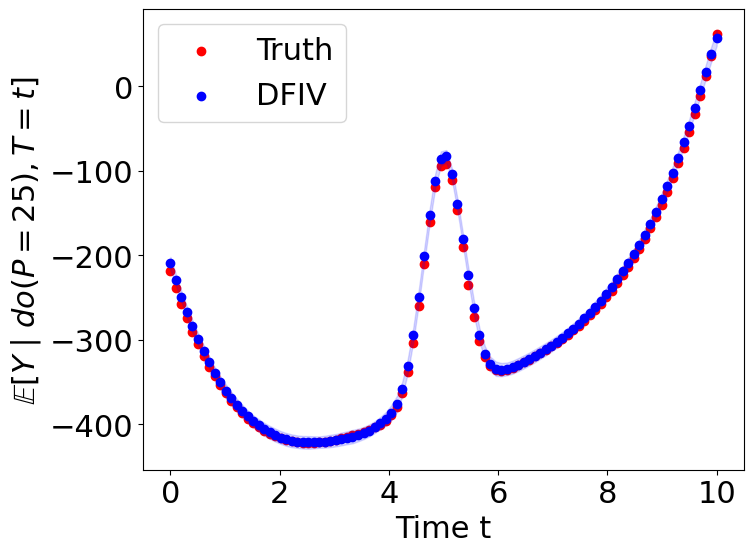

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
# fig.set_figheight(5)
# fig.set_figwidth(8)
time = time.squeeze()
l1 = ax.scatter(time, true_demand, color='r', label='Truth')
l2 = ax.scatter(time, mean_pred_demand, color='b', label='DFIV')
# l3 = ax.scatter(time, pred_demand_best, color='orange', label='DFIV')
ax.legend()

ax.set_xlabel('Time t')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=25), T=t]$')
# plt.fill_between(time, mean_pred_demand-error_min_pred_demand, mean_pred_demand+error_max_pred_demand, alpha=0.15, color='b')
plt.fill_between(time, mean_pred_demand-std_pred_demand, mean_pred_demand+std_pred_demand, alpha=0.15, color='b')
plt.savefig("images/CATE_demand_original.pdf")
plt.show()

## ATE

In [18]:
num_point = 50

In [19]:
# vary p: fix t = E[t] = 5, S = E[S] = 4
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price = np.linspace(10, 25, num_point)
time_range = np.linspace(0.0, 10, num_point)
# emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [20]:
time_range = np.linspace(0.0, 10, num_point)
tmp_time = []
for time in time_range:
    pred = psi(function, time)
    tmp_time.append(pred)
G = np.mean(tmp_time) * np.mean(emotion_range)
# G = np.mean(psi(function, time)) * np.mean(emotion_range)
coef = G - 2
offset = 100 + 10 * G

true_demand = coef * price + offset

In [21]:
# pred_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_model, p, covariate)))
#     pred_demand.append(pred)

In [22]:
pred_demands = []

for id in tqdm(result_df['id'], desc='model', position=0):
    run_path = f'{entity}/{project}/{id}'
    dfiv_model = load_dfiv_model(run_path)
    
    # Generate the combinations of emotion and time
    emotions, times = np.meshgrid(emotion_range, time_range)
    combs = np.column_stack((emotions.ravel(), times.ravel()))  
    
    # Create the covariates array
    time = np.repeat(combs[:, 1].reshape(-1, 1), num_point, axis=0)
    emotion = np.repeat(combs[:, 0].reshape(-1, 1), num_point, axis=0)
    covariates = np.concatenate((time, emotion), axis=1)

    prices = np.tile(price[:, np.newaxis], (len(combs), 1))
    
    tmp_pred_demands = predict_dfiv_model(dfiv_model, prices, covariates).reshape(-1, num_point)
    mean_pred_demand = np.mean(tmp_pred_demands, axis=0).reshape(1, -1)

    pred_demands.append(mean_pred_demand)

pred_demands = np.vstack(pred_demands)

model:   0%|          | 0/30 [00:00<?, ?it/s]

In [23]:
pred_demands.shape

(30, 50)

In [24]:
mean_pred_demand = np.mean(pred_demands, axis=0)
min_pred_demand = np.min(pred_demands, axis=0)
max_pred_demand = np.max(pred_demands, axis=0)
std_pred_demand = np.std(pred_demands, axis=0)
error_min_pred_demand = mean_pred_demand - min_pred_demand
error_max_pred_demand = max_pred_demand - mean_pred_demand

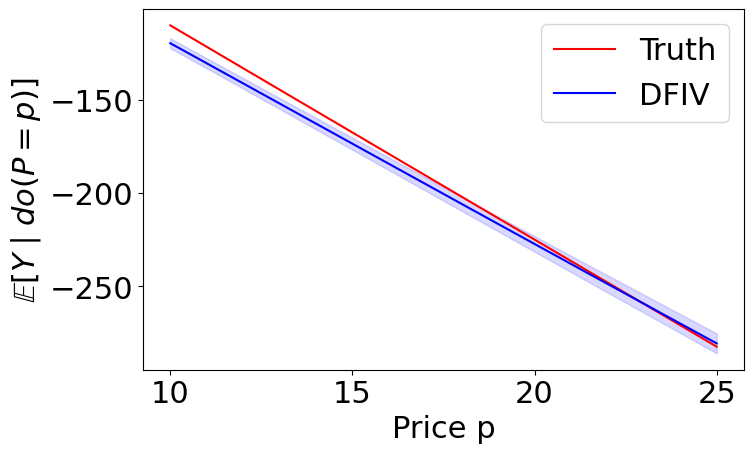

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
price = price.squeeze()
fig.set_figheight(5)
fig.set_figwidth(8)
l1 = ax.plot(price, true_demand, color='red', label='Truth')
l2 = ax.plot(price, mean_pred_demand, color='blue', label='DFIV')
ax.legend()

ax.set_xlabel('Price p')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=p)]$')
# plt.fill_between(price, mean_pred_demand-error_min_pred_demand, mean_pred_demand+error_max_pred_demand, alpha=0.15, color='b')
plt.fill_between(price, mean_pred_demand-std_pred_demand, mean_pred_demand+std_pred_demand, alpha=0.15, color='b')
# ax.set_ylim([-300, -100])
plt.savefig("images/ATE_demand_original.pdf")
plt.show()


# Demand Revised

In [26]:
function = 'revised'
noise_price_mean, noise_price_std = 0, 1

In [27]:
result_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['function'] == 'revised')]
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['hetero'] == False)]
# result_df['rho'] = result_df['config'].apply(lambda x: x['data_configs']['rho'])
# result_df.groupby('rho').count()
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['rho'] == rho)]
# result_df

## CATE

In [28]:
num_point = 50

In [29]:
# obtain the approx range of the expected price
boostrap_size = 5000
time = np.linspace(0.0, 10, boostrap_size)
# E[C] = 0, E[V] = noise_price_bias -> E[P | t] = 25 + (0 + 3) * psi(t) + noise_price_bias
exp_true_price =  25 + (0 + 3) * psi(function, time) + noise_price_mean
exp_min_price, exp_max_price = np.round(np.min(exp_true_price)), np.round(np.max(exp_true_price))
exp_max_price

18.0

In [30]:
# vary t: fix p = 25, S = E[S]
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price_val = exp_max_price
price = np.ones(num_point) * exp_max_price
time = np.linspace(0.0, 10, num_point)
cost = np.random.normal(0, 1.0, num_point)
noise_price = np.random.normal(noise_price_mean, noise_price_std, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [31]:
time = time_range.copy()   
true_demand = f(function, price, time, np.mean(emotion_range))

In [32]:
# np.round(np.min(true_price)), np.round(np.max(true_price))

In [33]:
pred_demands = []

for id in tqdm(result_df['id'], position=0, leave=True, desc='model'):
    run_path = f'{entity}/{project}/{id}'
    dfiv_model = load_dfiv_model(run_path)
    
    emotions = np.repeat(emotion_range.reshape(-1, 1), num_point, axis=0)
    prices = np.tile(price[:, np.newaxis], (len(emotion_range), 1))
    times = np.tile(time[:, np.newaxis], (len(emotion_range), 1))
    covariates = np.c_[times, emotions]
    
    tmp_demands = predict_dfiv_model(dfiv_model, prices, covariates).reshape(-1, num_point)
    
    mean_demand = tmp_demands.mean(axis=0).reshape(1, -1)
    pred_demands.append(mean_demand)

pred_demands = np.vstack(pred_demands)
print(pred_demands.shape)

model:   0%|          | 0/30 [00:00<?, ?it/s]

(30, 50)


In [34]:
mean_pred_demand = np.mean(pred_demands, axis=0)
min_pred_demand = np.min(pred_demands, axis=0)
max_pred_demand = np.max(pred_demands, axis=0)
error_min_pred_demand = mean_pred_demand - min_pred_demand
error_max_pred_demand = max_pred_demand - mean_pred_demand

In [35]:
matplotlib.rcParams.update({'font.size': 22})

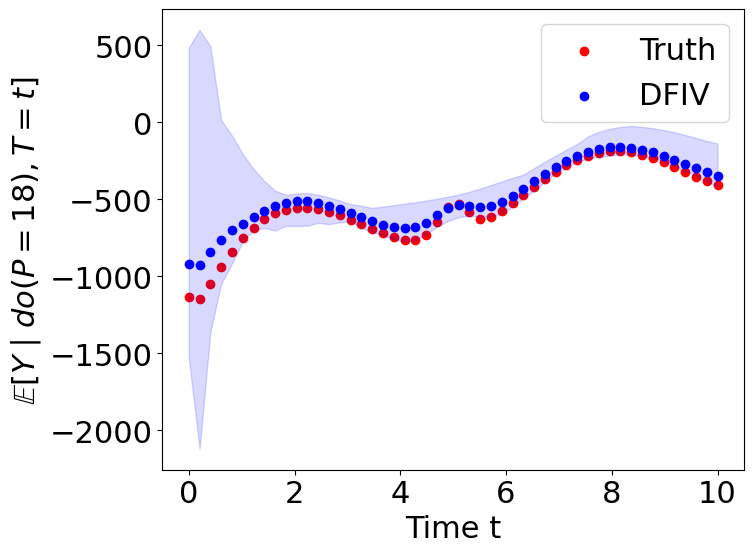

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
time = time.squeeze()
l1 = ax.scatter(time, true_demand, color='red', label='Truth')
l2 = ax.scatter(time, mean_pred_demand, color='blue', label='DFIV')
ax.legend()

ax.set_xlabel('Time t')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=18), T=t]$')
plt.fill_between(time, mean_pred_demand-error_min_pred_demand, mean_pred_demand+error_max_pred_demand, alpha=0.15, color='b')
# ax.set_ylim([-2400, 0])
plt.savefig(f'images/CATE_demand_revised.pdf')
plt.show()

## ATE

In [37]:
num_point = 50

In [38]:
# vary p: fix t = E[t] = 5, S = E[S] = 4
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price = np.linspace(exp_min_price, exp_max_price, num_point)
time_range = np.linspace(0.0, 10, num_point)
# emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [39]:
G = np.mean(psi(function, time)) * np.mean(emotion_range)
coef = G - 2
offset = 100 + 10 * G

true_demand = coef * price + offset

In [40]:
pred_demands = []

for id in tqdm(result_df['id'], desc='model', position=0):
    run_path = f'{entity}/{project}/{id}'
    dfiv_model = load_dfiv_model(run_path)
    
    # Generate the combinations of emotion and time
    emotions, times = np.meshgrid(emotion_range, time_range)
    combs = np.column_stack((emotions.ravel(), times.ravel()))  
    
    # Create the covariates array
    time = np.repeat(combs[:, 1].reshape(-1, 1), num_point, axis=0)
    emotion = np.repeat(combs[:, 0].reshape(-1, 1), num_point, axis=0)
    covariates = np.concatenate((time, emotion), axis=1)

    prices = np.tile(price[:, np.newaxis], (len(combs), 1))
    
    tmp_pred_demands = predict_dfiv_model(dfiv_model, prices, covariates).reshape(-1, num_point)
    mean_pred_demand = np.mean(tmp_pred_demands, axis=0).reshape(1, -1)

    pred_demands.append(mean_pred_demand)

pred_demands = np.vstack(pred_demands)

model:   0%|          | 0/30 [00:00<?, ?it/s]

In [41]:
mean_pred_demand = np.mean(pred_demands, axis=0)
min_pred_demand = np.min(pred_demands, axis=0)
max_pred_demand = np.max(pred_demands, axis=0)
std_pred_demand = np.std(pred_demands, axis=0)
error_min_pred_demand = mean_pred_demand - min_pred_demand
error_max_pred_demand = max_pred_demand - mean_pred_demand

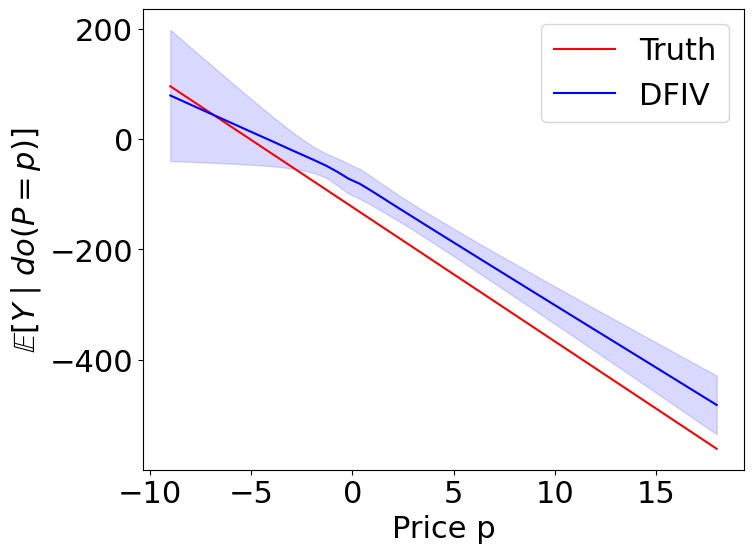

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
price = price.squeeze()
l1 = ax.plot(price, true_demand, color='red', label='Truth')
l2 = ax.plot(price, mean_pred_demand, color='blue', label='DFIV')
ax.legend()

ax.set_xlabel('Price p')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=p)]$')
plt.fill_between(price, mean_pred_demand-std_pred_demand, mean_pred_demand+std_pred_demand, alpha=0.15, color='b')
# ax.set_ylim([-300, -100])
plt.savefig("images/ATE_demand_revised.pdf")
plt.show()


## spaceIV

In [43]:
from src.data.demand_design_parcs_revise import generate_train_demand_design_parcs_revise
import os

ModuleNotFoundError: No module named 'src.data.demand_design_parcs_revise'

In [ ]:
# Get the current working directory
prev_dir = os.getcwd()
print("Prev working directory:", prev_dir)

# Change the working directory
os.chdir("../")

# Check the new working directory
print("Updated working directory:", os.getcwd())

In [ ]:
# deadloop, invertible matrix
valid_seed = get_valid_seed()

In [ ]:
def get_valid_seed():
    seed = 0
    valid = False
    while not valid:
        try: 
            train_data = generate_train_demand_design(data_size=5000, rho=0.5, rand_seed=seed)
            I = train_data.instrumental
            covariate = train_data.covariate
            treatment = train_data.treatment
            X = np.c_[covariate, treatment]
            Y = train_data.outcome
            beta_placeholder = np.zeros((X.shape[1], 1))
            beta_hat, _ = spaceiv(I, X, Y, beta_placeholder)
            valid = True
        except Exception as e:
            seed += 1
            print(e)
    print(f'Valid seed: {seed}')
    return seed